<a href="https://colab.research.google.com/github/luis-arrieta/Foundations-of-AI-and-Machine-Learning/blob/main/Health_of_the_United_States_economy_since_2010.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

count   164.0000000000
mean      0.8428658537
std       1.2415603508
min       0.0500000000
25%       0.0900000000
50%       0.1600000000
75%       1.2325000000
max       5.3300000000
Name: Federal Funds Rate, dtype: float64
count   164.0000000000
mean      2.5375067683
std       2.0461797303
min      -0.2299300000
25%       1.3638050000
50%       1.9619800000
75%       2.8213000000
max       8.9329900000
Name: CPI Inflation, dtype: float64


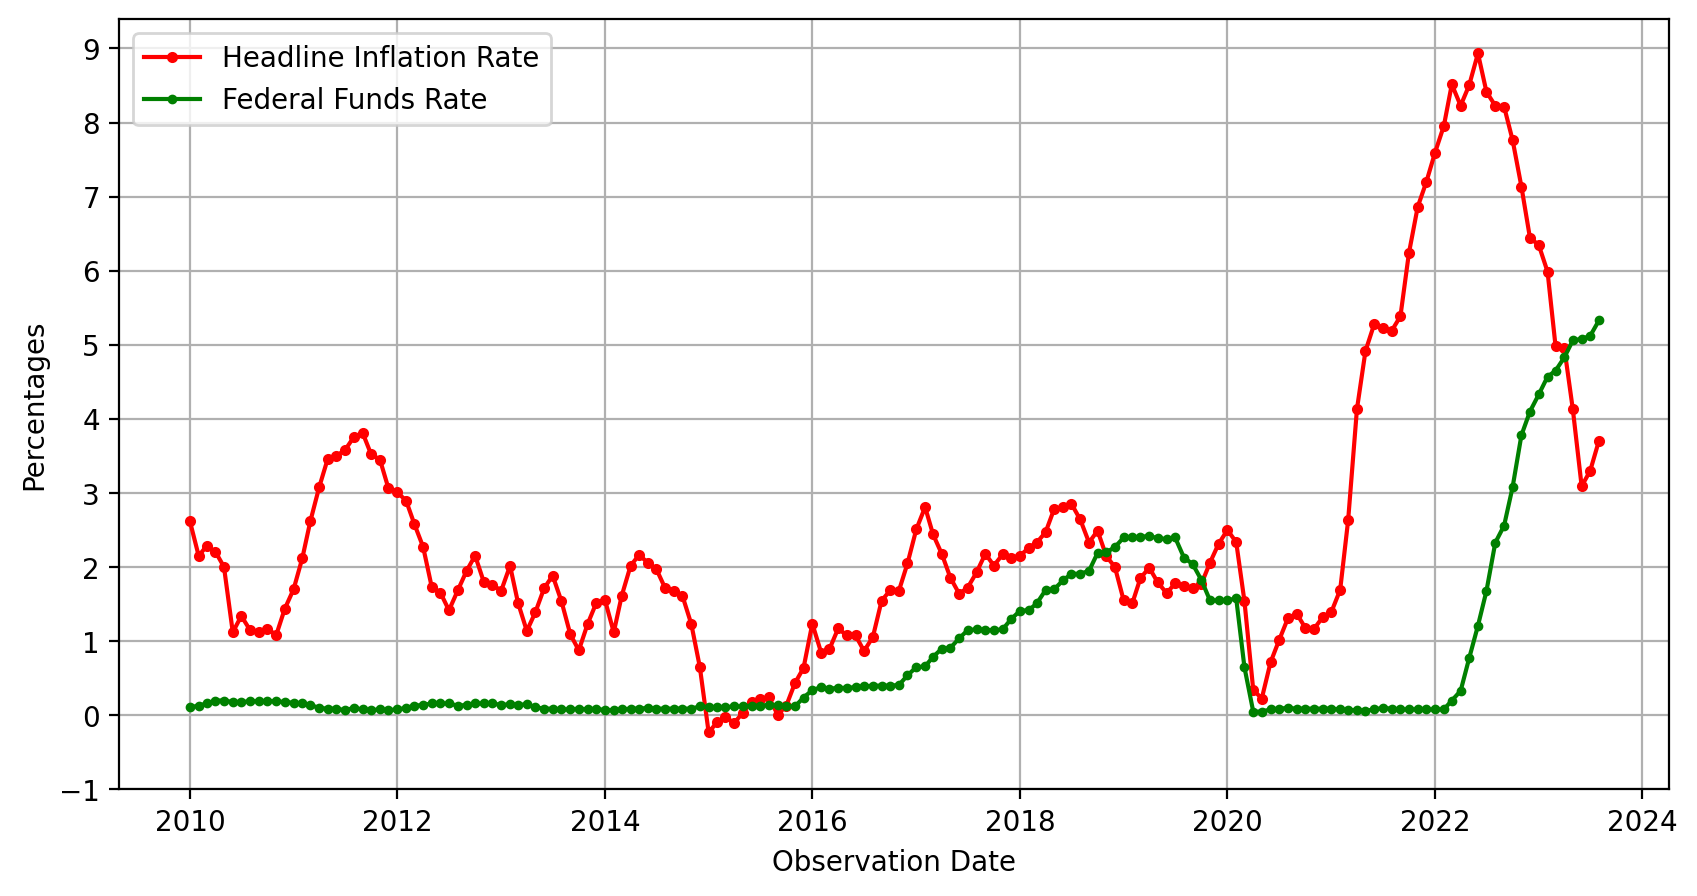

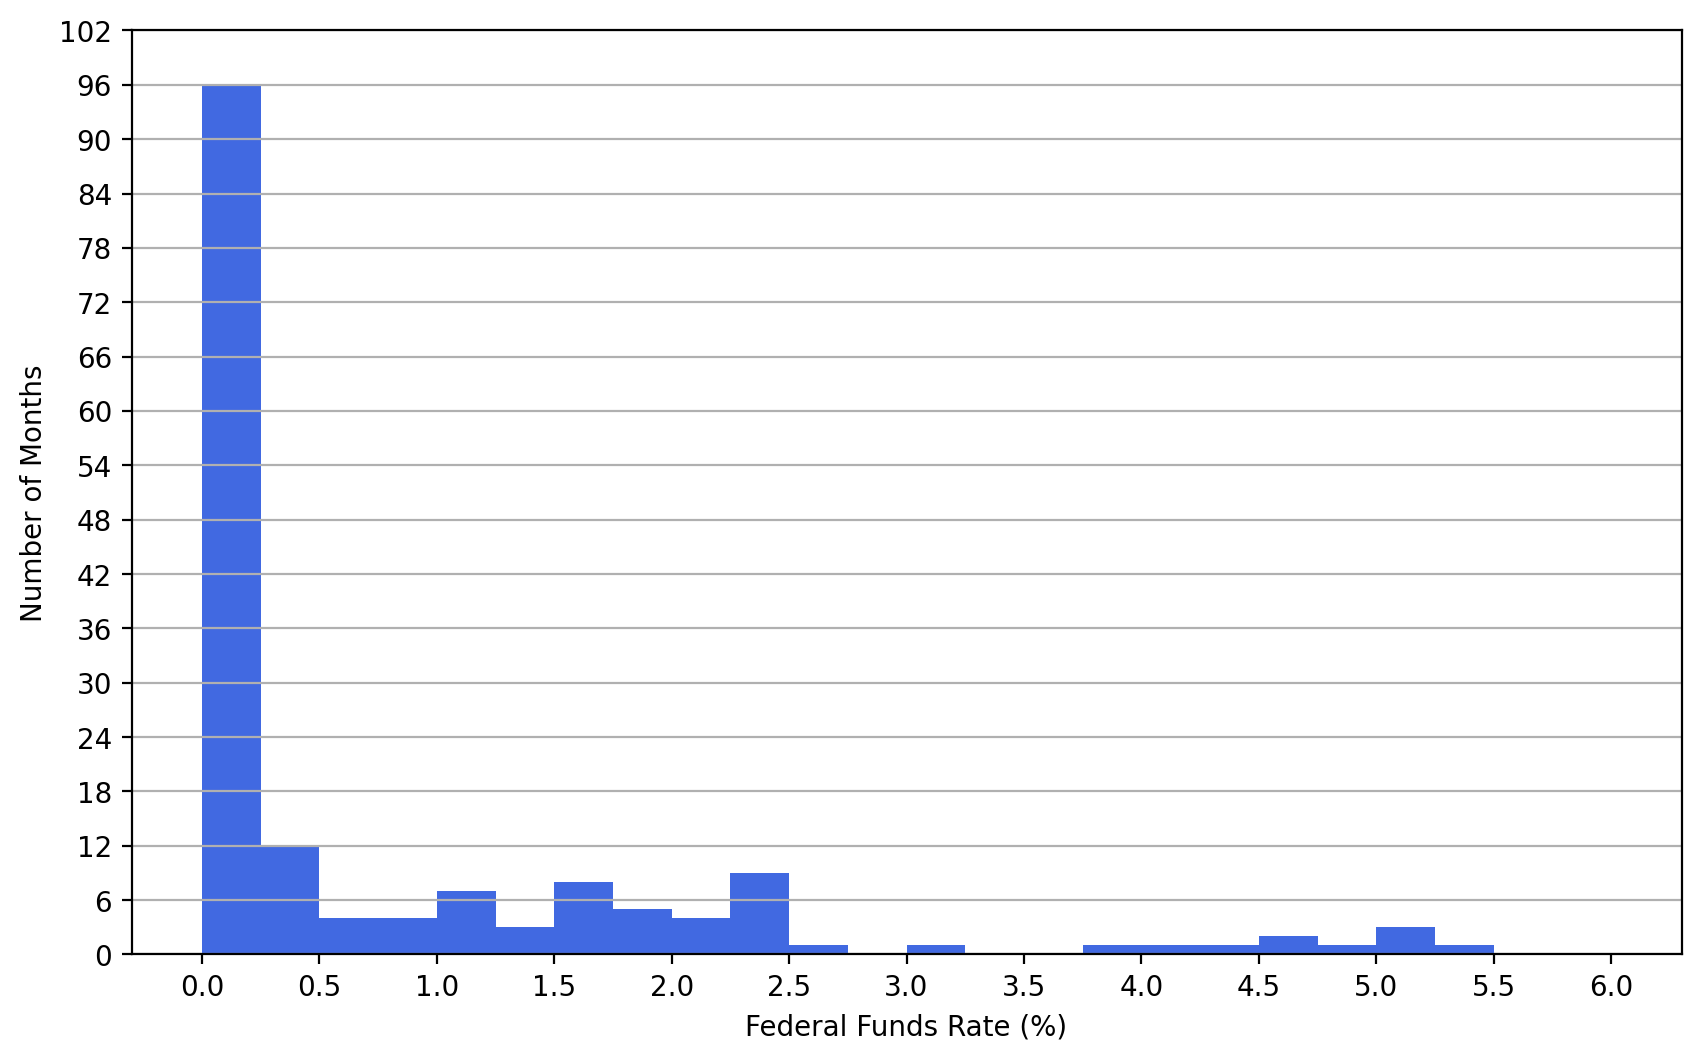

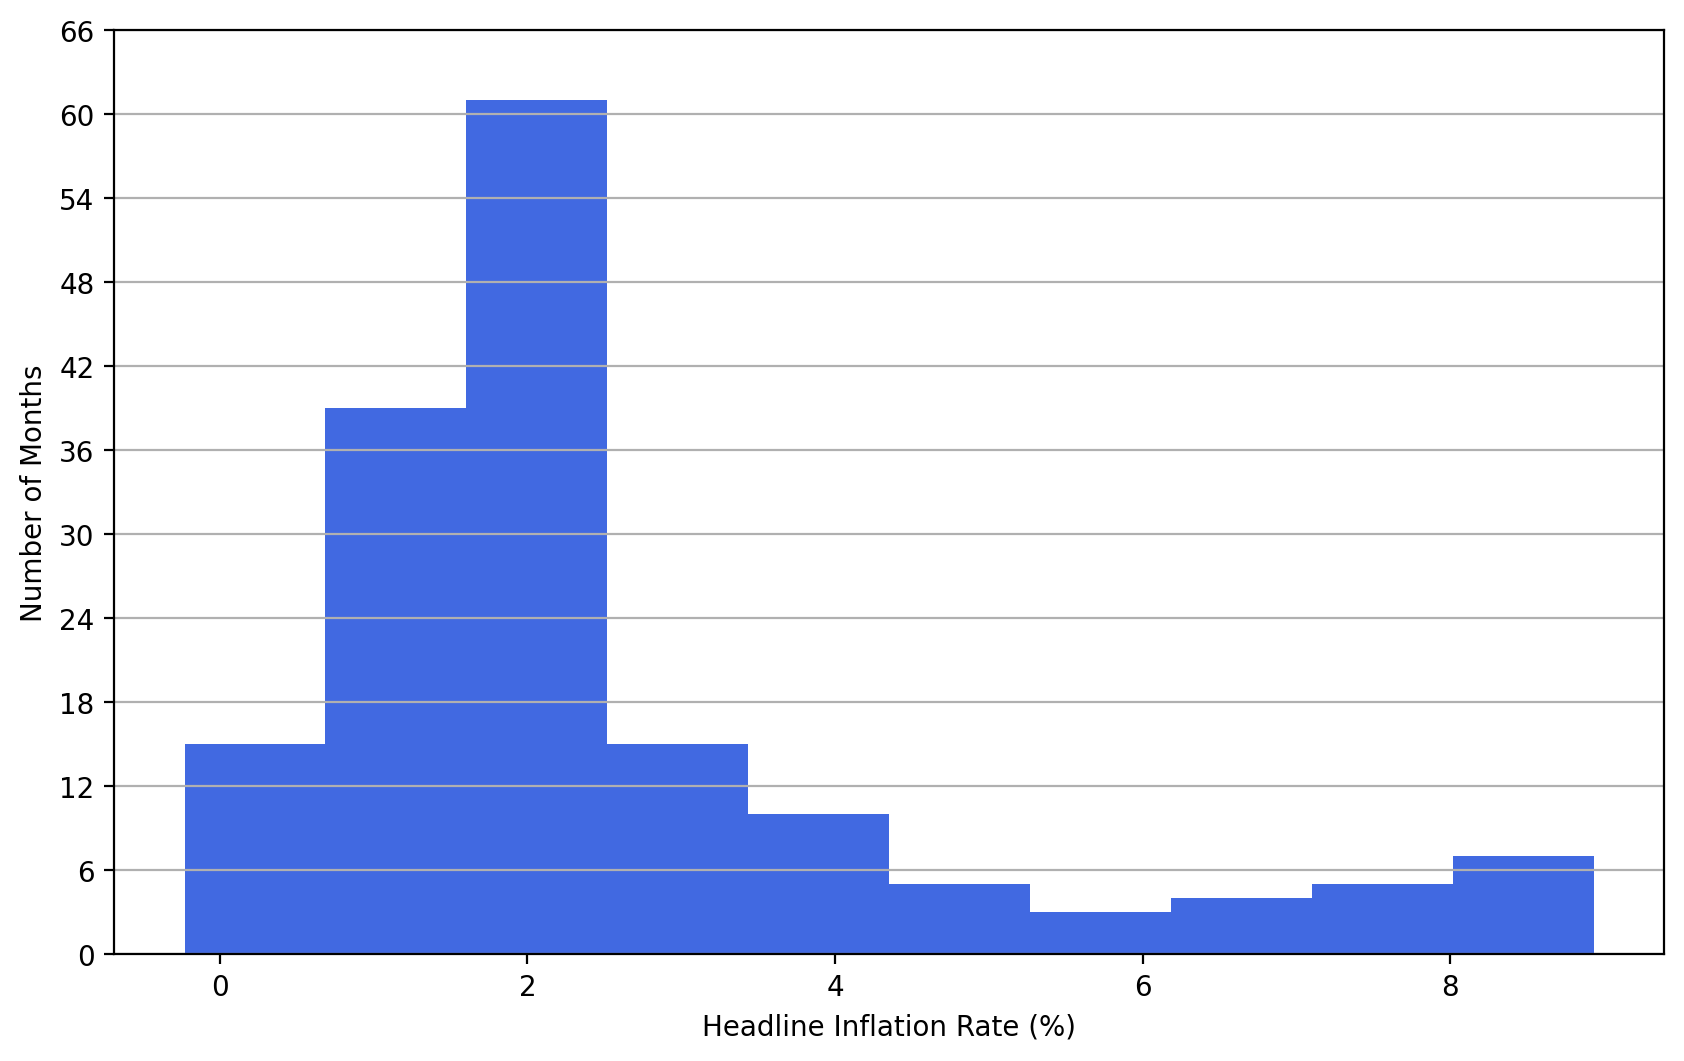

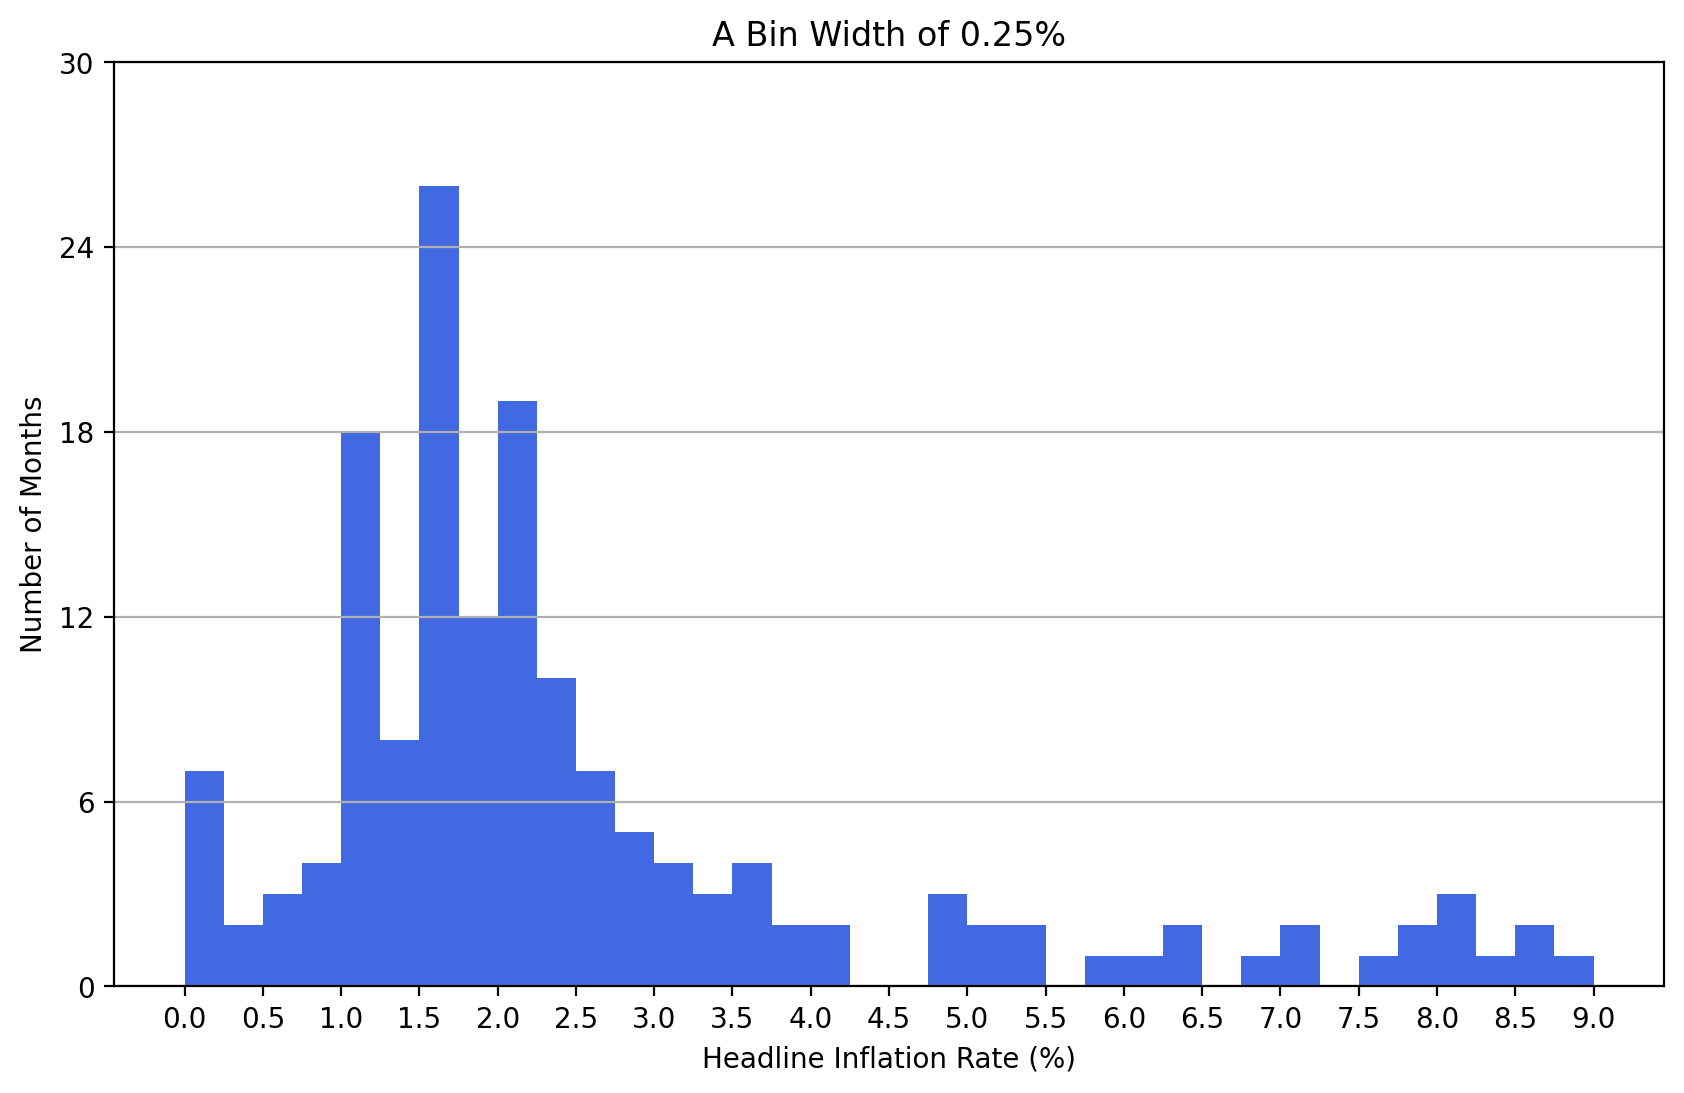

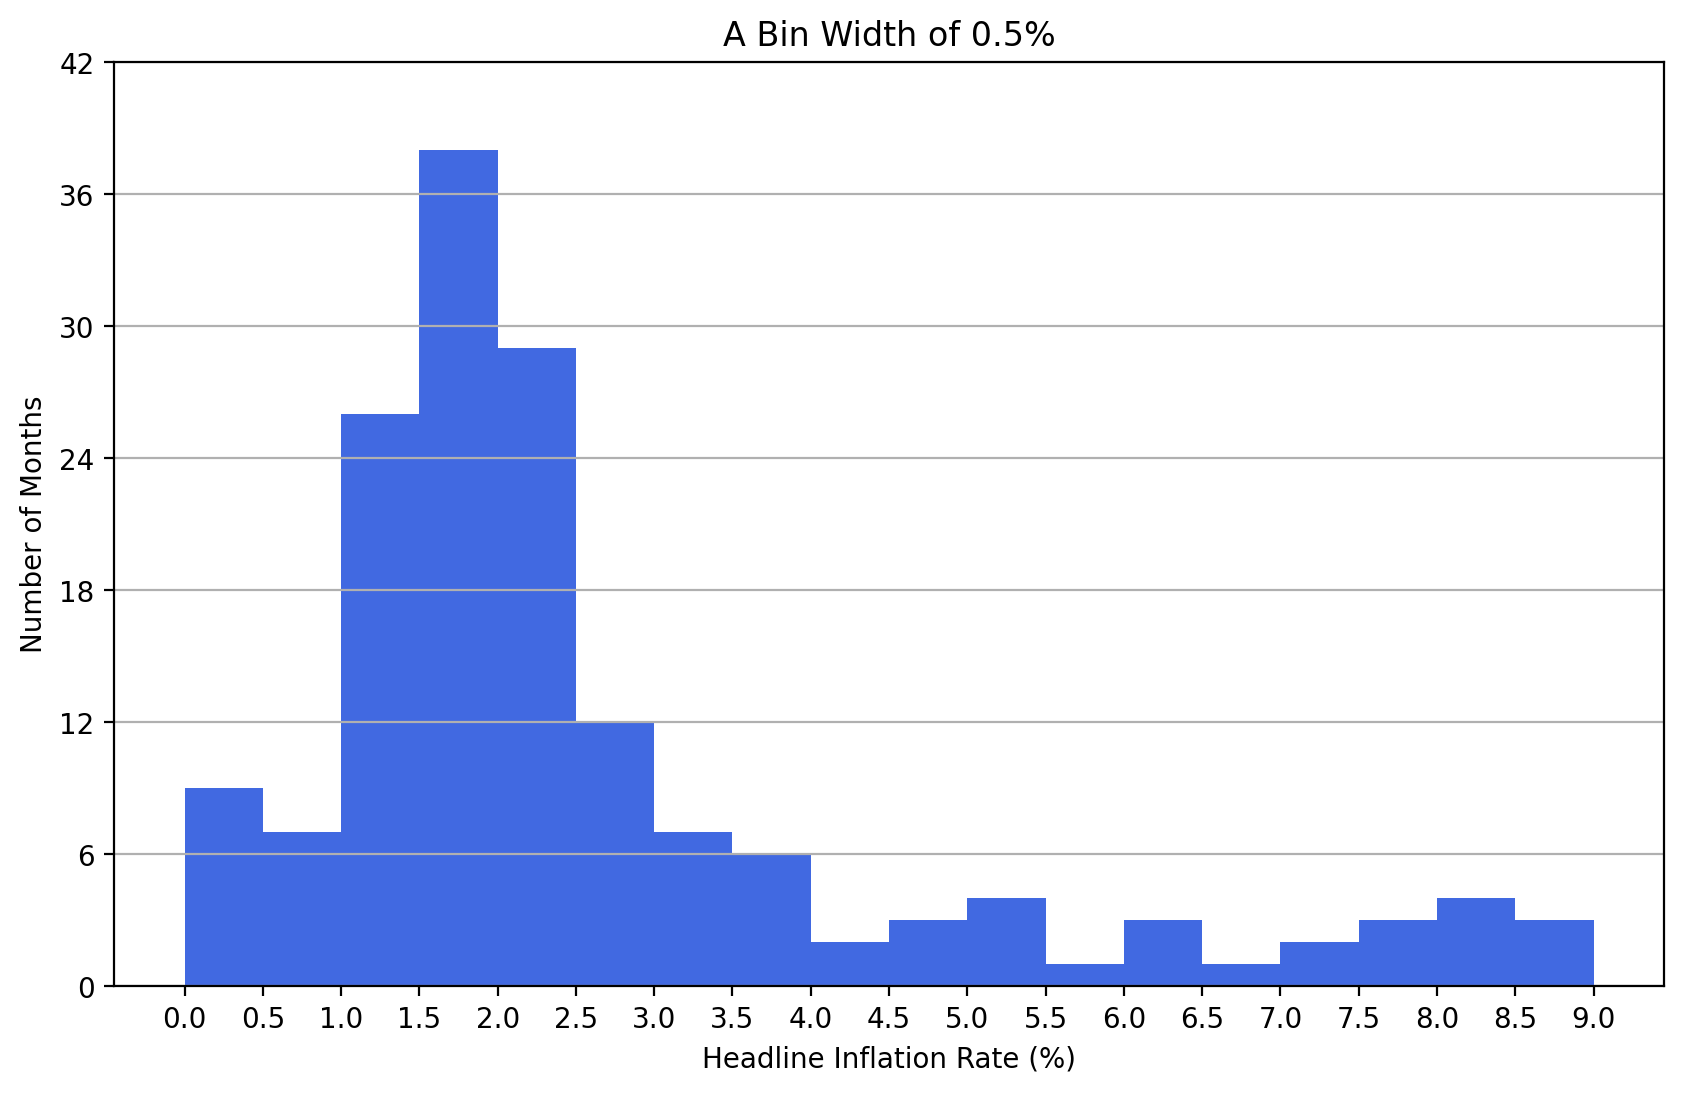

In [ ]:
# -*- coding: utf-8 -*-
"""
Name: Module 1 US Inflation 2010 to 2023.py
Course: Data Preparation and Analysis
Created Date: September 30, 2023
Author: Ming-Long Lam, Ph.D.
Organization: Illinois Institute of Technology
"""

import matplotlib.pyplot as plt
import numpy
import pandas
import sys

# Set some options for printing all the columns
numpy.set_printoptions(precision = 10, threshold = sys.maxsize)
numpy.set_printoptions(linewidth = numpy.inf)

pandas.set_option('display.max_columns', None)
pandas.set_option('display.expand_frame_repr', False)
pandas.set_option('max_colwidth', None)

pandas.options.display.float_format = '{:,.10f}'.format

econ_data = pandas.read_excel('/content/US_Inflation_2010_2023.xlsx')

obs_date = pandas.to_datetime(econ_data['observation_date'], format='%Y-%m-%d')

obs_year = obs_date.dt.year
obs_month = obs_date.dt.month

# Descriptive Statistics
print(econ_data['Federal Funds Rate'].describe())
print(econ_data['CPI Inflation'].describe())

# Time Plot of both series versus observation date
plt.figure(figsize = (10,5), dpi = 200)
plt.plot(obs_date, econ_data['CPI Inflation'], marker = 'o', markersize = 3, c = 'red', label = 'Headline Inflation Rate')
plt.plot(obs_date, econ_data['Federal Funds Rate'], marker = '.', markersize = 5, c = 'green', label = 'Federal Funds Rate')
plt.xlabel('Observation Date')
plt.ylabel('Percentages')
plt.yticks(range(-1,10))
plt.legend()
plt.grid()
plt.show()

# Histogram of Federal Funds Rate
# Since FOMC always moves the federal funds rate by 1/4%, we draw the histogram with this increment.
plt.figure(figsize = (10,6), dpi = 200)
plt.hist(econ_data['Federal Funds Rate'], bins = numpy.arange(0.0, 6.25, 0.25), color = 'royalblue')
plt.xlabel('Federal Funds Rate (%)')
plt.ylabel('Number of Months')
plt.xticks(numpy.arange(0.0,6.5,0.5))
plt.yticks(range(0,108,6))
plt.grid(axis = 'y')
plt.show()

# Histogram of Headline Inflation with default settings
plt.figure(figsize = (10,6), dpi = 200)
plt.hist(econ_data['CPI Inflation'], color = 'royalblue')
plt.xlabel('Headline Inflation Rate (%)')
plt.ylabel('Number of Months')
plt.yticks(range(0,72,6))
plt.grid(axis = 'y')
plt.show()

def univariate (y):
   '''Compute four descriptive statistics from first principles.

   Argument:
   ---------
   y : a Pandas Series of numeric values

   Output:
   -------
   y_nvalid : number of non-NaN values
   y_min : the minimum value
   y_max : the maximum value
   y_mean : the arithmetic mean
   '''

   # Initialize
   y_nvalid = 0
   y_min = None
   y_max = None
   y_mean = None

   # Loop through all the elements
   for u in y:
      if (not numpy.isnan(u)):
         y_nvalid = y_nvalid + 1

         if (y_min is not None):
            if (u < y_min):
               y_min = u
         else:
            y_min = u

         if (y_max is not None):
            if (u > y_max):
               y_max = u
         else:
            y_max = u

         if (y_mean is not None):
            y_mean = y_mean + u
         else:
            y_mean = u

   # Finalize
   if (y_nvalid > 0):
      y_mean = y_mean / y_nvalid

   return (y_nvalid, y_min, y_max, y_mean)

def shimazaki_criterion (y, d_list):
   '''Compute the criterion based on the Shimazaki H. and Shinomoto S. (2007) paper.

   Argument:
   ---------
   y : a Pandas Series of numeric values
   d_list : a list of candidates of bin-widths

   Output:
   -------
   number_bins : a list of number of bins (length is same as d_list)
   matrix_boundary : a list of bin boundaries, each element is a list
   criterion_list : a list of criterion values
   '''

   number_bins = []
   matrix_boundary = []
   criterion_list = []

   y_nvalid, y_min, y_max, y_mean = univariate (y)

   if (y_nvalid <= 0):
      raise ValueError('There are no non-missing values in the data vector.')
   else:

      # Loop through the bin width candidates
      for delta in d_list:
         y_middle = delta * numpy.round(y_mean / delta)
         n_bin_left = numpy.ceil((y_middle - y_min) / delta)
         n_bin_right = numpy.ceil((y_max - y_middle) / delta)
         y_low = y_middle - n_bin_left * delta

         # Assign observations to bins starting from 0
         list_boundary = []
         n_bin = n_bin_left + n_bin_right
         bin_index = 0
         bin_boundary = y_low
         for i in numpy.arange(n_bin):
            bin_boundary = bin_boundary + delta
            bin_index = numpy.where(y > bin_boundary, i+1, bin_index)
            list_boundary.append(bin_boundary)

         # Count the number of observations in each bins
         uvalue, ucount = numpy.unique(bin_index, return_counts = True)

         # Calculate the average frequency
         mean_ucount = numpy.mean(ucount)
         ssd_ucount = numpy.mean(numpy.power((ucount - mean_ucount), 2))
         criterion = (2.0 * mean_ucount - ssd_ucount) / delta / delta

         number_bins.append(n_bin)
         matrix_boundary.append(list_boundary)
         criterion_list.append(criterion)

   return(number_bins, matrix_boundary, criterion_list)

d_list = []
d0_list = [1.0, 1.25, 2.0, 2.5, 5.0]

for p in [-2, -1, 0]:
   d_list.extend([u * numpy.power(10.0, p) for u in d0_list])

number_bins, matrix_boundary, criterion_list = shimazaki_criterion (econ_data['CPI Inflation'], d_list)

result_df = pandas.DataFrame(columns = ['Bin-Width','N Bin','Criterion'])
result_df['Bin-Width'] = d_list
result_df['N Bin'] = number_bins
result_df['Criterion'] = criterion_list

# Histogram of Headline Inflation with a bin width of 0.25%
bin_boundary = matrix_boundary[8]
plt.figure(figsize = (10,6), dpi = 200)
plt.title('A Bin Width of 0.25%')
plt.hist(econ_data['CPI Inflation'], bins = bin_boundary, color = 'royalblue')
plt.xlabel('Headline Inflation Rate (%)')
plt.ylabel('Number of Months')
plt.xticks(numpy.arange(0.0, 9.5, 0.5))
plt.yticks(range(0,36,6))
plt.grid(axis = 'y')
plt.show()

# Histogram of Headline Inflation with a bin width of 0.5%
bin_boundary = matrix_boundary[9]
plt.figure(figsize = (10,6), dpi = 200)
plt.title('A Bin Width of 0.5%')
plt.hist(econ_data['CPI Inflation'], bins = bin_boundary, color = 'royalblue')
plt.xlabel('Headline Inflation Rate (%)')
plt.ylabel('Number of Months')
plt.xticks(numpy.arange(0.0, 9.5, 0.5))
plt.yticks(range(0,48,6))
plt.grid(axis = 'y')
plt.show()
